# **Emotion Detection**

In [2]:
base_dir = "/content/drive/MyDrive/datasets/emotion"
train_dir = base_dir+"/train"
test_dir = base_dir+"/test"
import os
import matplotlib.pyplot as plt
import random

28709


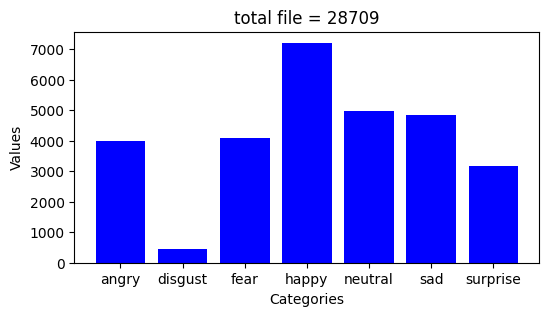

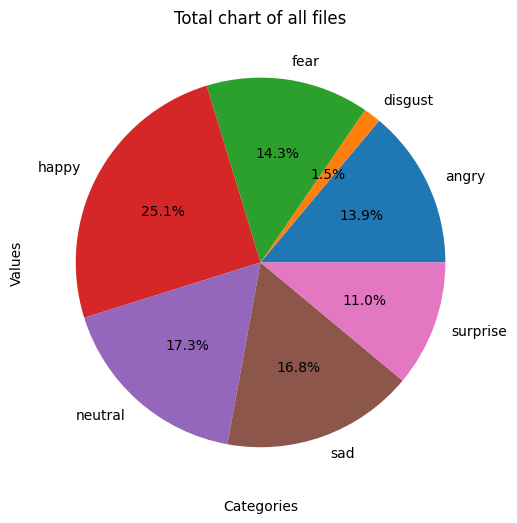

In [40]:

# all files in every folder
def count_file_in_Dir(dir):
  counts = {}
  for item in os.listdir(dir):
    path = os.path.join(dir,item)
    if os.path.isdir(path):
      counts[item] = len(os.listdir(path))
  return counts
# plot graph of all files
def plot_graph_dir_bar(counts):
  plt.figure(figsize=(6,3))
  print(sum(counts.values()))
  plt.bar(counts.keys(),counts.values(),color="blue")

  plt.title(f"total file = {sum(counts.values())}")
  plt.xlabel("Categories")
  plt.ylabel("Values")

def plot_graph_dir_pie(counts):
  data = {key: value / sum(counts.values()) for key, value in counts.items()}
  plt.figure(figsize=(6,6))
  plt.pie(data.values(),labels=counts.keys(),autopct='%1.1f%%')

  plt.title("Total chart of all files")
  plt.xlabel("Categories")
  plt.ylabel("Values")

cnt = count_file_in_Dir(train_dir)
total_size = sum(cnt.values())
plot_graph_dir_bar(cnt)
plot_graph_dir_pie(cnt)


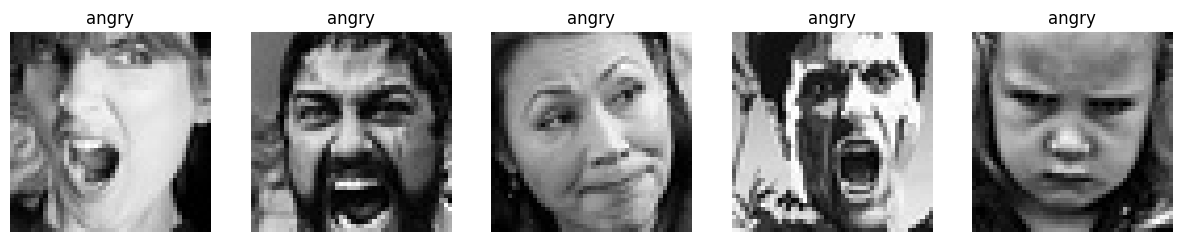

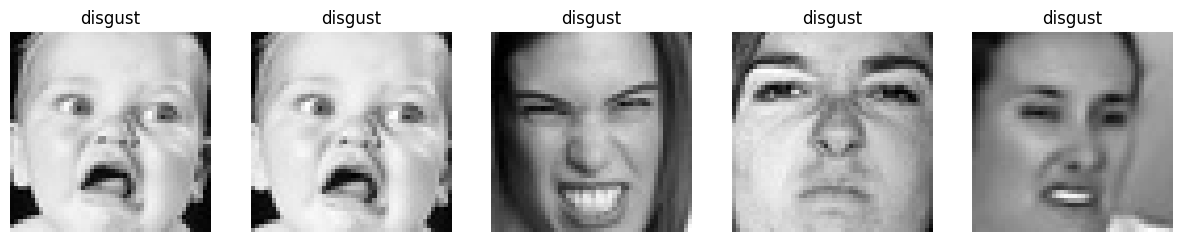

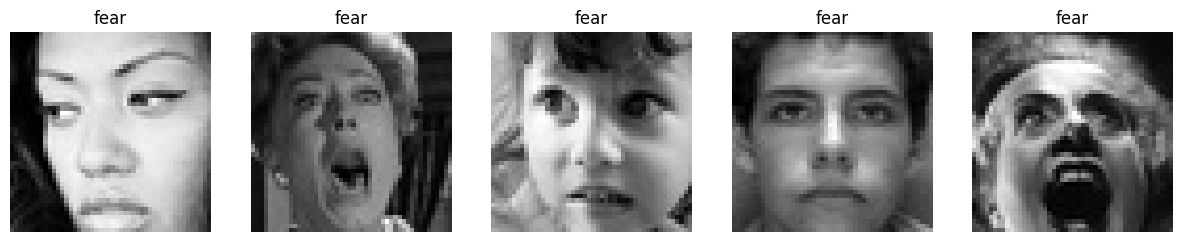

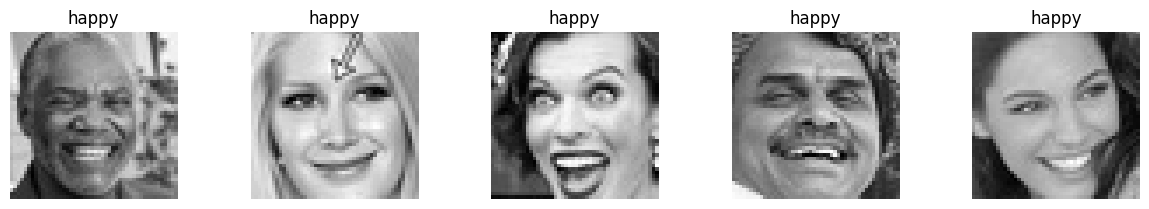

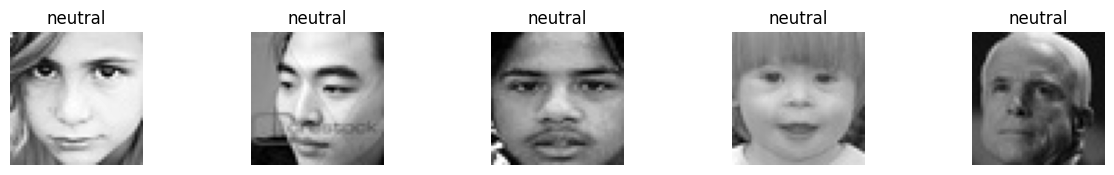

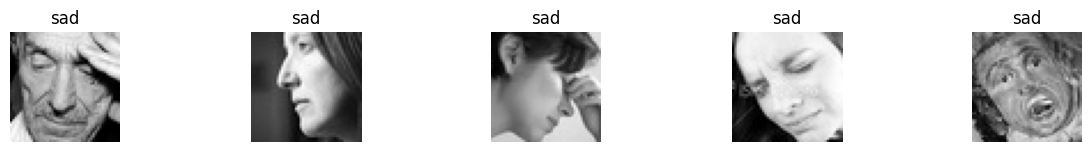

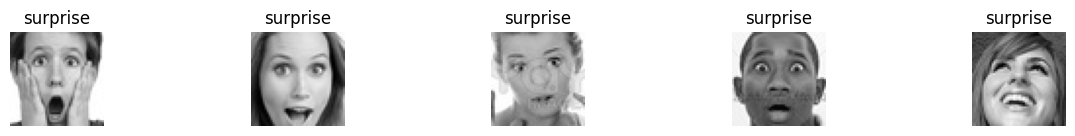

In [41]:
# print random image from each class
def show_img_in_dir():
  n = 5
  classes = os.listdir(train_dir)
  for index,i in enumerate(classes):
    plt.figure(figsize=(15,10))
    full_path = os.path.join(train_dir,i)
    img_arr = os.listdir(full_path)
    selected_img = random.sample(img_arr,n)
    for idx,j in enumerate(selected_img):
      img_path = os.path.join(full_path,j)
      img = plt.imread(img_path)

      plt.subplot(index+1,5,idx+1)
      plt.imshow(img,cmap="gray")
      plt.title(i)
      plt.axis("off")
    plt.show()
show_img_in_dir()

In [42]:
# print size of an image
import cv2
def print_img_size():
  img_path = train_dir+"/angry/Training_10118481.jpg"
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  print("shape = ",img.shape)
print_img_size()

shape =  (48, 48)


In [43]:
# custom data generator
img_w, img_h = 224,224
batch_size = 64
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

In [44]:
# for training
train_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=(img_w,img_h),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    subset="training"
)
# for validation
val_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=(img_w,img_h),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    subset="validation",
)
# for testing
test_gen = data_gen.flow_from_directory(
    test_dir,
    target_size=(img_w,img_h),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [45]:
print("Train class label = ",train_gen.class_indices)
print("Validation class label = ",val_gen.class_indices)
print("Test class label = ",test_gen.class_indices)


Train class label =  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class label =  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class label =  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [8]:
# early stopping, callbacks, logger, error
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
check_path = base_dir+"/cnn.h5"
# checkpoint you to save the model's weights during training
checkpoint = ModelCheckpoint(
    filepath=check_path,
    save_best_only_true=True,
    verbose=1,
    mode="min",
    monitor="val_loss"
)

# save the model and stop the training when val_loss diff of 3 epcoh is 0
earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# change the model rate of training
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)

# csv log file
csv_log = CSVLogger(base_dir+"/model.log")

In [46]:
# no of epoch for train,val,test
train_epoch_step = train_gen.samples // train_gen.batch_size + 1
val_epoch_step = val_gen.samples // val_gen.batch_size + 1
test_epoch_step = test_gen.samples // test_gen.batch_size + 1

train_epoch_step, val_epoch_step, test_epoch_step

(359, 90, 113)

In [47]:
# class weight for imbalanced dataset
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
classes = np.array(train_gen.classes)
classes
class_weight = compute_class_weight(
    class_weight = "balanced",
    classes=np.unique(classes),
    y=classes
)
class_weight_dict = dict(enumerate(class_weight))
class_weight_dict,train_gen.class_indices


({0: 1.0266404434114071,
  1: 9.401555464592715,
  2: 1.0009587727708533,
  3: 0.5684585684585685,
  4: 0.826068191627104,
  5: 0.8491570541259982,
  6: 1.2933160650937552},
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [11]:
# resnet model import
from tensorflow.keras.applications import ResNet50V2
resnet = ResNet50V2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

94668760/94668760 [==============================] - 1s 0us/step


In [18]:
resnet.trainable = False

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape,Flatten,Dense,BatchNormalization,Dropout

def create_model():
  model = Sequential([
    resnet,
    Flatten(),
    Dense(64,activation="relu"),
    Dense(7,activation="softmax")
    ])
  return model


In [20]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                6422592   
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 29987847 (114.39 MB)
Trainable params: 6423047 (24.50 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [49]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [22]:
callbacks = [checkpoint, earlystop, reduce_lr, csv_log]

In [35]:
history = model.fit(
    train_gen,
    steps_per_epoch=10,
    epochs=1,
    validation_data=val_gen,
    validation_steps=10,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

NameError: name 'train_gen' is not defined

In [25]:
import time
import numpy as np
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print('TPU not found. Defaulting to CPU or GPU.')
    strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)

TPU not found. Defaulting to CPU or GPU.
Number of accelerators:  1


In [4]:
# print random image from each class
test_img = []
def show_img_in_dir():
  n = 1
  classes = os.listdir(train_dir)
  for index,i in enumerate(classes):
    full_path = os.path.join(train_dir,i)
    img_arr = os.listdir(full_path)
    selected_img = random.sample(img_arr,n)
    for idx,j in enumerate(selected_img):
      img_path = os.path.join(full_path,j)
      test_img.append(img_path)
show_img_in_dir()
test_img

['/content/drive/MyDrive/datasets/emotion/train/angry/Training_90018744.jpg',
 '/content/drive/MyDrive/datasets/emotion/train/disgust/Training_19204784.jpg',
 '/content/drive/MyDrive/datasets/emotion/train/fear/Training_66772954.jpg',
 '/content/drive/MyDrive/datasets/emotion/train/happy/Training_77922689.jpg',
 '/content/drive/MyDrive/datasets/emotion/train/neutral/Training_18530980.jpg',
 '/content/drive/MyDrive/datasets/emotion/train/sad/Training_73075893.jpg',
 '/content/drive/MyDrive/datasets/emotion/train/surprise/Training_52985506.jpg']

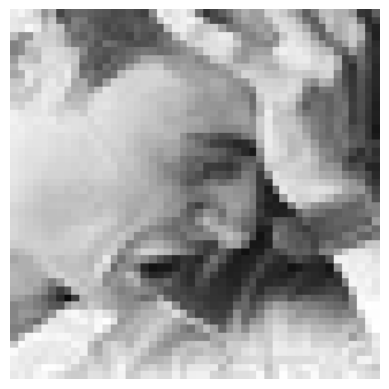

1/1 [==============================] - 1s 1s/step
Pred =  disgust actual =  /content/drive/MyDrive/datasets/emotion/train/angry/Training_90018744.jpg


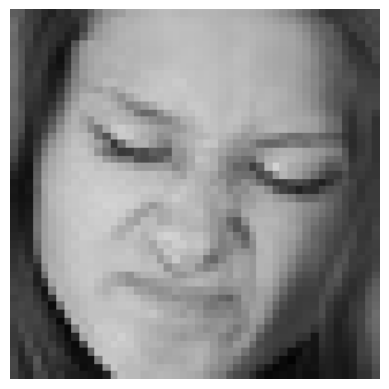

1/1 [==============================] - 0s 31ms/step
Pred =  disgust actual =  /content/drive/MyDrive/datasets/emotion/train/disgust/Training_19204784.jpg


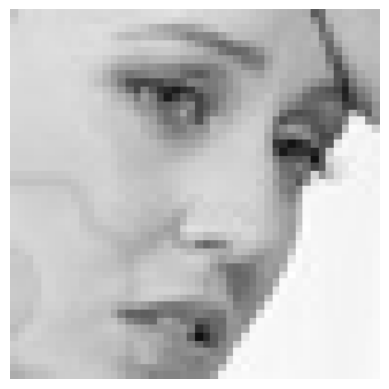

1/1 [==============================] - 0s 31ms/step
Pred =  disgust actual =  /content/drive/MyDrive/datasets/emotion/train/fear/Training_66772954.jpg


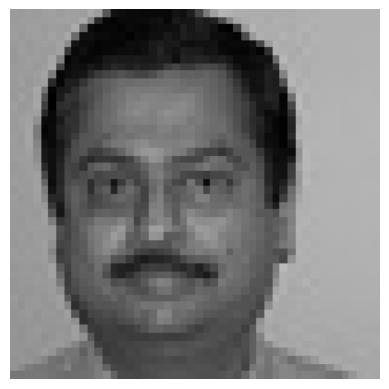

1/1 [==============================] - 0s 31ms/step
Pred =  disgust actual =  /content/drive/MyDrive/datasets/emotion/train/happy/Training_77922689.jpg


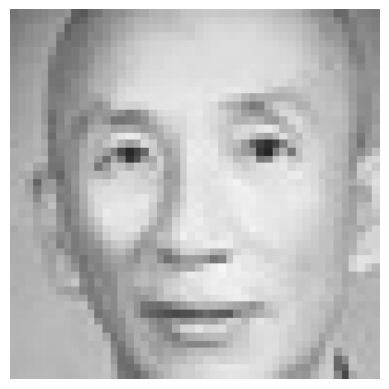

1/1 [==============================] - 0s 31ms/step
Pred =  disgust actual =  /content/drive/MyDrive/datasets/emotion/train/neutral/Training_18530980.jpg


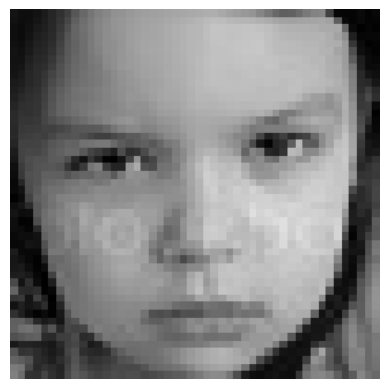

1/1 [==============================] - 0s 64ms/step
Pred =  disgust actual =  /content/drive/MyDrive/datasets/emotion/train/sad/Training_73075893.jpg


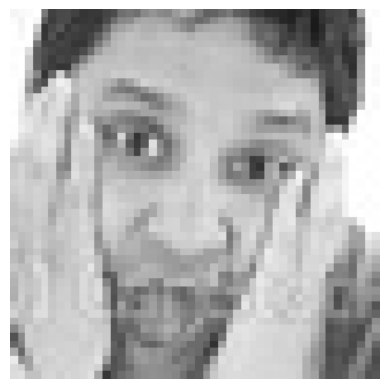

1/1 [==============================] - 0s 38ms/step
Pred =  disgust actual =  /content/drive/MyDrive/datasets/emotion/train/surprise/Training_52985506.jpg


In [34]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array,load_img

from PIL import Image

emotion_label = {"angry":0,"disgust":1,"fear":2,"happy":3,"neutral":4,"sad":5,"suprise":6}
index_to_emotion = {v:k for k,v in emotion_label.items()}

loaded_model = load_model(base_dir+"/cnn.h5")
pred = []


def process_image(img_pil):
  img = img_pil.resize((224,224))
  img_arr = img_to_array(img)
  img_arr = np.expand_dims(img_arr, axis=0)
  img_arr /= 255.0
  return img_arr

def predict_emotion(img):
  proc_img = process_image(load_img(img))
  pred = loaded_model.predict(proc_img)
  pred_class = np.argmax(pred,axis=1)
  pred_emotion = index_to_emotion.get(pred_class[0],"Unknown Emotion")
  return pred_emotion

def show_image(img):
  img_show = load_img(img, target_size=(224, 224))
  plt.imshow(img_show)
  plt.axis('off')
  plt.show()
for i in test_img:
  show_image(i)
  actual = i
  pred = predict_emotion(i)
  print("Pred = ",pred,"actual = ",actual)

In [39]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50V2
resnet = ResNet50V2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
resnet.trainable = False
model2 = Sequential()

model2.add(resnet)
model2.add(Flatten())
model2.add(Dense(7,activation='softmax'))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model2.fit(
    train_gen,
    steps_per_epoch=train_epoch_step,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_epoch_step,
    class_weight=class_weight_dict,
)

Epoch 1/10
  3/359 [..............................] - ETA: 1:59:30 - loss: 11.6367 - accuracy: 0.1354